# Disentangled RNNs for Mouse Switching Dataset
The dataset below is from [Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/7E0NM5). Each row corresponds to a trial, and the columns correspond to the trial number, block position, target direction, choice direction, and reward outcome, as well as the session and mouse identifiers and task conditions.

| Trial | blockTrial | Decision | Switch | Reward | Condition | Target | blockLength | Session | Mouse |
|-------|------------|----------|--------|--------|-----------|--------|-------------|---------|-------|
| 11.0  | 11.0       | 1.0      | 0.0    | 1.0    | 90-10     | 1.0    | 58.0        | m1_77   | m1    |
| 12.0  | 12.0       | 1.0      | 0.0    | 1.0    | 90-10     | 1.0    | 58.0        | m1_77   | m1    |
| 13.0  | 13.0       | 1.0      | 0.0    | 1.0    | 90-10     | 1.0    | 58.0        | m1_77   | m1    |

In [1]:
from disentangled_rnns.library import get_datasets
from disentangled_rnns.library import two_armed_bandits
from disentangled_rnns.library import rnn_utils
from disentangled_rnns.library import disrnn
import switch_utils
import optax


addr = "/Users/michaelcondon/workspaces/pbm_group2/2ABT_behavior_models/bandit_data.csv"
# list of tuples containing datasets for train, val, test.
ds_list = switch_utils.get_dataset(addr, tr_prop=0.7, va_prop=0.15, te_prop=0.15)


/Users/michaelcondon/workspaces/pbm_group2/disentangled_rnns/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
update_mlp_shape = (5,5,5)
choice_mlp_shape = (2,2)
latent_size = 5

def make_network():
  return disrnn.HkDisRNN(update_mlp_shape=update_mlp_shape,
                        choice_mlp_shape=choice_mlp_shape,
                        latent_size=latent_size,
                        obs_size=2, target_size=2)

learning_rate = 1e-3
opt = optax.adam(learning_rate)

Step 1000 of 1000. Training Loss: 4.13e+04. Validation Loss: 4.13e+04


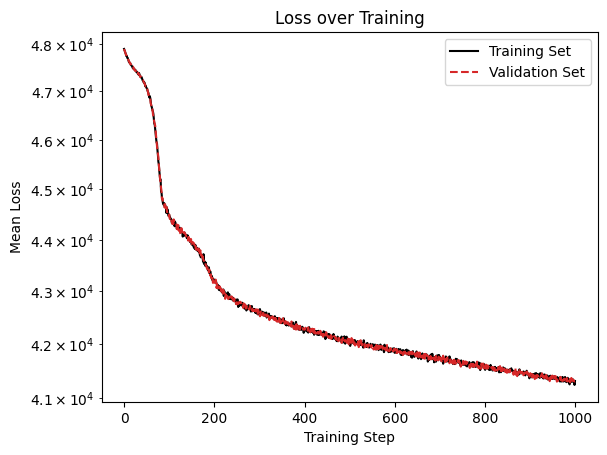

In [18]:
m_i, dataset_tr, dataset_va, dataset_te = ds_list[1]

# Train one step to initialize
params, opt_state, losses = rnn_utils.train_network(
   make_network,
    dataset_tr,
    dataset_va,
    opt = optax.adam(1e-2),
    l_train="penalized_categorical",
    n_steps=0)

# Train additional steps
n_steps = 1000
params, opt_state, losses = rnn_utils.train_network(
make_network,
    dataset_tr,
    dataset_va,
    l_train="penalized_categorical",
    params=params,
    opt_state=opt_state,
    opt = optax.adam(1e-3),
    penalty_scale = 1e-3,
    n_steps=n_steps,
    do_plot = True)

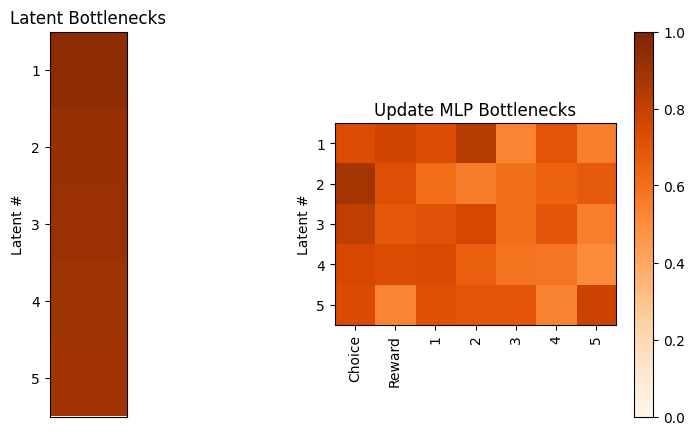

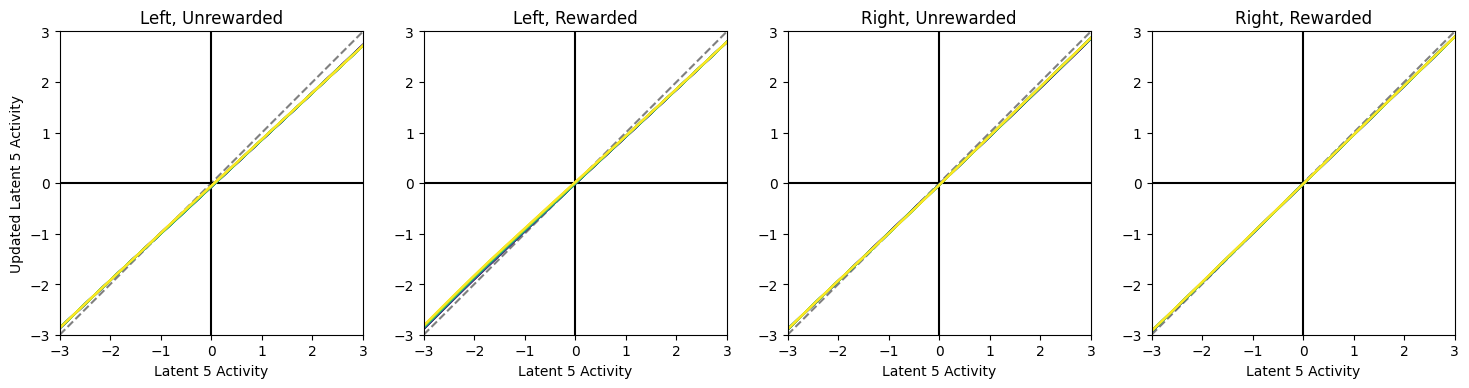

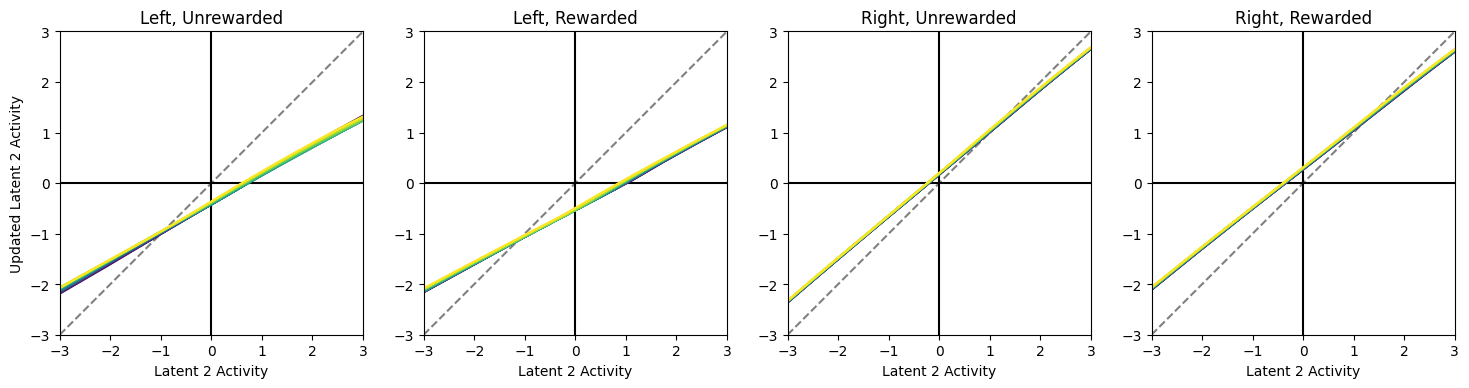

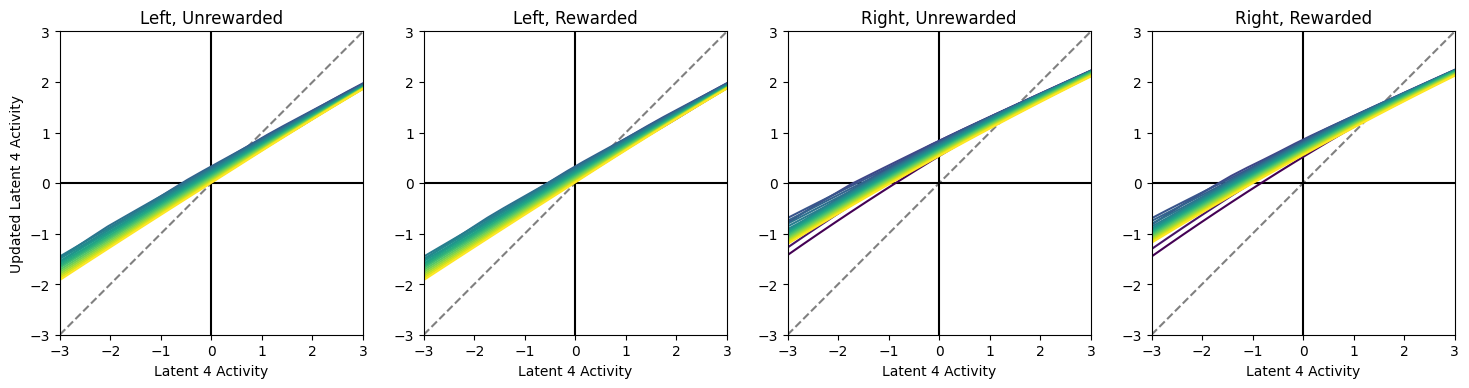

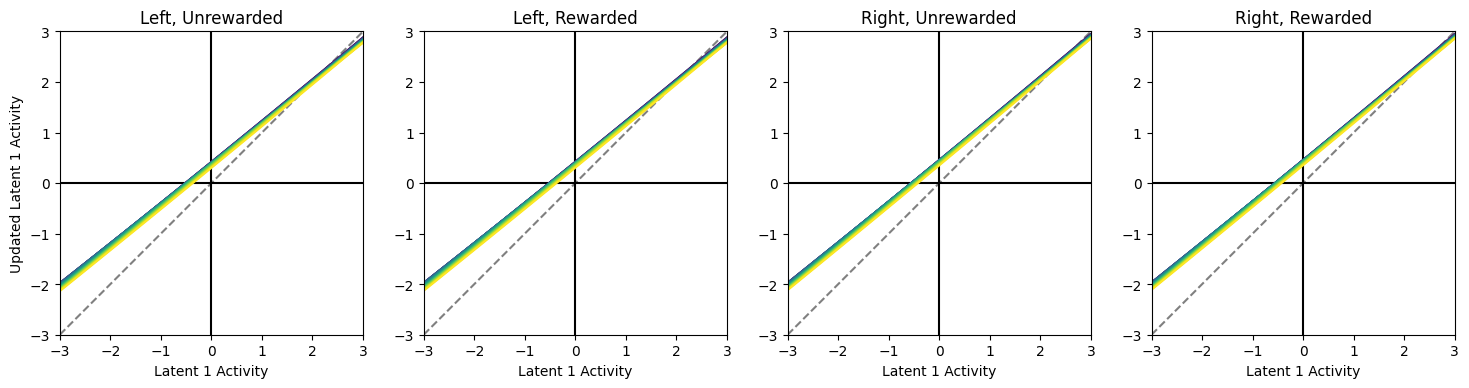

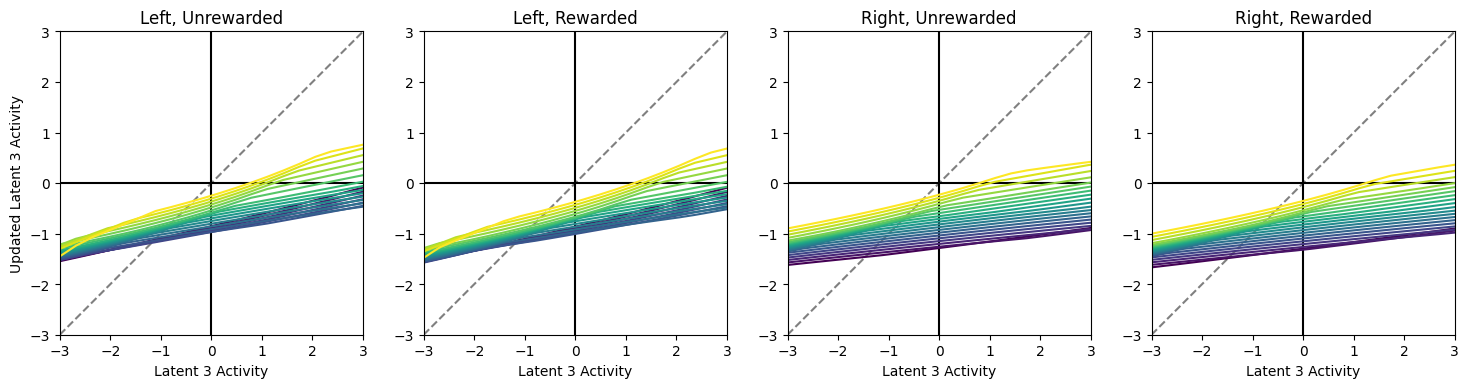

In [19]:
from matplotlib import pyplot as plt

# Eval mode runs the network with no noise
def make_network_eval():
  return disrnn.HkDisRNN(update_mlp_shape=update_mlp_shape,
                        choice_mlp_shape=choice_mlp_shape,
                        latent_size=latent_size,
                        obs_size=2, target_size=2,
                        eval_mode=True)


disrnn.plot_bottlenecks(params, make_network_eval)
plt.show()
disrnn.plot_update_rules(params, make_network_eval)
plt.show()